In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:



import numpy as np 
import pandas as pd 
import warnings 
warnings.filterwarnings("ignore")
import tensorflow as tf 


print(tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D,concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from attention import Attention_Block
# from attention import attention_block
from tensorflow.keras.layers import Attention
from step_attention import AttentionAugmentation2D, _normalize_depth_vars
# from keras.models import load_model

# In[2]:


# from google.colab import drive
# drive.mount('/content/drive')



# In[3]:


from loss import discounted_l1, max_displacement_error,v3_displacement_error
import math
import pickle5 as pickle
import matplotlib.pyplot as plt
from numpy import array
# import horovod.tensorflow.keras as hvd

2.2.0


In [2]:

# hvd.init()

# In[4]:

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"


gpus = tf.config.experimental.list_logical_devices('GPU')
print(gpus)


if gpus:
    
    try:
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except:
        print('checking gpu error')
print('checking GPUs')


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config=tf.compat.v1.ConfigProto()
# config.gpu_options.visible_device_list= '0,1'
config.gpu_options.allow_growth=True

config.log_device_placement=True
# config.visible_device_list =2
sess=tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(sess)


# In[5]:


from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import initializers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

from load_data import load_data
import os

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
checking gpu error
checking GPUs
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN X (Pascal), pci bus id: 0000:0a:00.0, compute capability: 6.1



In [3]:
prefix ='/home/lab1/repo/planning/traj_pred/data/'
train_raw, test_raw=None, None
for i in range(3):
    name_tr= prefix+'cyc_train_set'+str(i)+'.npy'
    name_te= prefix+'cyc_test_set'+str(i)+'.npy'
    tr = np.load(name_tr,allow_pickle=True).astype(float)
    te = np.load(name_te,allow_pickle=True).astype(float)
    if train_raw is None:
        train_raw=tr
    else:
        train_raw= np.vstack((train_raw, tr))
    
    if test_raw is None:
        test_raw=te
    else:
        test_raw= np.vstack((test_raw, te))

print(train_raw.shape, test_raw.shape)

(2570, 11, 4) (65, 20, 4)


In [4]:
np.random.shuffle(train_raw)
np.random.shuffle(test_raw)
if len(train_raw)>300000:
    max_n=300000
else:
    max_n=len(train_raw)
test_maxn=int(max_n*0.4)
train_set = train_raw[:max_n]
X_train=train_set[:,:10,2:4]
y_train=train_set[:,10,2:4]

test_set = test_raw[:test_maxn]
X_test=test_set[:,:10,2:4]
y_test=test_set[:,10,2:4]
y = test_set[:,10:,2:4]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, y.shape)

(300000, 10, 2) (300000, 2) (8447, 10, 2) (8447, 2) (8447, 10, 2)


In [5]:
# print(X_position.shape, y.shape, X.shape)
print(X_train.shape, y_train.shape)
print(y_train[0])

(300000, 10, 2) (300000, 2)
[-21.32397461   8.5925293 ]


In [6]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=1)

X_train, X_val, y_train, y_val= \
train_test_split(X_train, y_train,test_size=0.1, random_state=1)

# X_val, X_test, y_val, y_test= \
# train_test_split(X_test, y_test,test_size=0.5, random_state=1)

print(X_val.shape, y_val.shape, X_train.shape, X_test.shape)

(30000, 10, 2) (30000, 2) (270000, 10, 2) (8447, 10, 2)


In [7]:

from pathlib import Path
home = str(Path.home())

In [8]:

# In[9]:


filters=20
kernel_size = (3,3)
strides = (1,1)
depth_k =0.2
depth_v =0.2

channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
print("before normalized k, v",depth_k,depth_k,strides)
depth_k, depth_v = _normalize_depth_vars(depth_k, depth_v, filters)
print("after normalized k, v",depth_k,depth_k,strides)


# In[10]:
time_step=10
tf.compat.v1.disable_eager_execution()

rnn = Sequential()
rnn.add(LSTM(128, return_sequences=True, kernel_regularizer='l1', input_shape=(time_step,2)))
rnn.add(LSTM(256, return_sequences=True, kernel_regularizer='l1',input_shape=(time_step,128)))
rnn.add(Reshape((time_step,16,16,1)))
rnn.summary()



cnn = Sequential()

cnn.add(Conv2D(1024, (4, 4),input_shape=(16, 16, 1)))
cnn.add(Conv2D(512, (2, 2)))
cnn.add(Conv2D(256, (4, 4)))
cnn.add(Conv2D(128, (2, 2)))
cnn.add(MaxPooling2D(2,2))
cnn.add(Conv2D(64, (2, 2)))
cnn.add(Conv2D(32, (2, 2)))
cnn.add(Conv2D(16, (2, 2)))

#attention block below
cnn.add(Conv2D(2 * depth_k + depth_k, (1, 1), strides))
cnn.add(AttentionAugmentation2D(depth_k, depth_v, num_heads=4, relative=True))

# cnn.add(Dropout(0.5))
cnn.add(Flatten())

 
cnn.add(Dense(128))
cnn.add(Dense(32))

cnn.summary() 



rnn2=Sequential()
rnn2.add(GRU(256, input_shape=(time_step,32)))


dense = Sequential()
dense.add(Dense(128))
dense.add(Dense(64))
dense.add(Dense(2)) # Model output

main_input = Input(shape=(time_step,2)) 
model = rnn(main_input)
model = TimeDistributed(cnn)(model) 
 # combine timedistributed cnn, attention, and fully connected network with rnn
model = rnn2(model)
model = dense(model) # add dense
final_model = Model(inputs=main_input, outputs=model)
final_model.summary()


before normalized k, v 0.2 0.2 (1, 1)
after normalized k, v 4 4 (1, 1)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           67072     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 256)           394240    
_________________________________________________________________
reshape (Reshape)            (None, 10, 16, 16, 1)     0         
Total params: 461,312
Trainable params: 461,312
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 1024)      17408     
________

In [13]:
# print(home)

In [9]:


n_batch = 32
n_epoch  = 150


checkpoint_path =home+ "/repo/planning/traj_pred/cyc_models/cyc_{epoch}.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)


 #(None, n_steps, n_features)

sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5, nesterov=True)
rmsprop =tf.keras.optimizers.RMSprop(learning_rate=0.001)



ftrl = tf.keras.optimizers.Ftrl(learning_rate=0.01)


mtrc = [tf.keras.metrics.MeanAbsoluteError()]
# [tf.keras.metrics.CosineSimilarity(axis=1)]

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.95)

adagrad = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule)
adadelta = tf.keras.optimizers.Adadelta(learning_rate=lr_schedule)

# to use customized loss, choose from  discounted_l1 or max_displacement_error function as loss parameter 
final_model.compile(loss=v3_displacement_error, optimizer=adadelta, metrics=mtrc)
# final_model.load_weights('/home/lab1/repo/models/lyft_vehicles/vehicles2_16.h5')

history=final_model.fit(X_train, 
                        y_train, epochs=n_epoch, 
                        batch_size=n_batch, 
                        verbose=2, 
                        validation_data=(X_val, y_val),
                        callbacks=[cp_callback])





Train on 270000 samples, validate on 30000 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.79122, saving model to /home/lab1/repo/planning/traj_pred/cyc_models/cyc_1.h5
270000/270000 - 1056s - loss: 2.3108 - mean_absolute_error: 0.5518 - val_loss: 0.7912 - val_mean_absolute_error: 0.1950
Epoch 2/150

Epoch 00002: val_loss did not improve from 0.79122
270000/270000 - 1061s - loss: 0.9452 - mean_absolute_error: 0.2866 - val_loss: 0.8402 - val_mean_absolute_error: 0.2148
Epoch 3/150

Epoch 00003: val_loss did not improve from 0.79122
270000/270000 - 1061s - loss: 0.8807 - mean_absolute_error: 0.2393 - val_loss: 0.9931 - val_mean_absolute_error: 0.3159
Epoch 4/150

Epoch 00004: val_loss did not improve from 0.79122
270000/270000 - 1061s - loss: 0.8426 - mean_absolute_error: 0.2139 - val_loss: 0.9022 - val_mean_absolute_error: 0.2596
Epoch 5/150

Epoch 00005: val_loss improved from 0.79122 to 0.72016, saving model to /home/lab1/repo/planning/traj_pred/cyc_models/cyc_5.h5
2

Epoch 37/150

Epoch 00037: val_loss improved from 0.27676 to 0.25853, saving model to /home/lab1/repo/planning/traj_pred/cyc_models/cyc_37.h5
270000/270000 - 1061s - loss: 0.2690 - mean_absolute_error: 0.0799 - val_loss: 0.2585 - val_mean_absolute_error: 0.0751
Epoch 38/150

Epoch 00038: val_loss did not improve from 0.25853
270000/270000 - 1060s - loss: 0.2622 - mean_absolute_error: 0.0789 - val_loss: 0.2643 - val_mean_absolute_error: 0.0817
Epoch 39/150

Epoch 00039: val_loss improved from 0.25853 to 0.24580, saving model to /home/lab1/repo/planning/traj_pred/cyc_models/cyc_39.h5
270000/270000 - 1060s - loss: 0.2558 - mean_absolute_error: 0.0782 - val_loss: 0.2458 - val_mean_absolute_error: 0.0738
Epoch 40/150

Epoch 00040: val_loss did not improve from 0.24580
270000/270000 - 1059s - loss: 0.2499 - mean_absolute_error: 0.0775 - val_loss: 0.2613 - val_mean_absolute_error: 0.0860
Epoch 41/150

Epoch 00041: val_loss improved from 0.24580 to 0.23873, saving model to /home/lab1/repo/plan

Epoch 73/150

Epoch 00073: val_loss improved from 0.15039 to 0.14717, saving model to /home/lab1/repo/planning/traj_pred/cyc_models/cyc_73.h5
270000/270000 - 1061s - loss: 0.1484 - mean_absolute_error: 0.0666 - val_loss: 0.1472 - val_mean_absolute_error: 0.0663
Epoch 74/150

Epoch 00074: val_loss did not improve from 0.14717
270000/270000 - 1063s - loss: 0.1470 - mean_absolute_error: 0.0664 - val_loss: 0.1473 - val_mean_absolute_error: 0.0670
Epoch 75/150

Epoch 00075: val_loss improved from 0.14717 to 0.14568, saving model to /home/lab1/repo/planning/traj_pred/cyc_models/cyc_75.h5
270000/270000 - 1062s - loss: 0.1457 - mean_absolute_error: 0.0663 - val_loss: 0.1457 - val_mean_absolute_error: 0.0666
Epoch 76/150

Epoch 00076: val_loss improved from 0.14568 to 0.14433, saving model to /home/lab1/repo/planning/traj_pred/cyc_models/cyc_76.h5
270000/270000 - 1062s - loss: 0.1446 - mean_absolute_error: 0.0662 - val_loss: 0.1443 - val_mean_absolute_error: 0.0663
Epoch 77/150

Epoch 00077: va

Epoch 108/150

Epoch 00108: val_loss improved from 0.12480 to 0.12470, saving model to /home/lab1/repo/planning/traj_pred/cyc_models/cyc_108.h5
270000/270000 - 1063s - loss: 0.1241 - mean_absolute_error: 0.0643 - val_loss: 0.1247 - val_mean_absolute_error: 0.0648
Epoch 109/150

Epoch 00109: val_loss improved from 0.12470 to 0.12457, saving model to /home/lab1/repo/planning/traj_pred/cyc_models/cyc_109.h5
270000/270000 - 1063s - loss: 0.1238 - mean_absolute_error: 0.0642 - val_loss: 0.1246 - val_mean_absolute_error: 0.0649
Epoch 110/150

Epoch 00110: val_loss did not improve from 0.12457
270000/270000 - 1063s - loss: 0.1235 - mean_absolute_error: 0.0642 - val_loss: 0.1250 - val_mean_absolute_error: 0.0653
Epoch 111/150

Epoch 00111: val_loss did not improve from 0.12457
270000/270000 - 1063s - loss: 0.1233 - mean_absolute_error: 0.0642 - val_loss: 0.1248 - val_mean_absolute_error: 0.0652
Epoch 112/150

Epoch 00112: val_loss improved from 0.12457 to 0.12367, saving model to /home/lab1/re

Epoch 142/150

Epoch 00142: val_loss improved from 0.11988 to 0.11972, saving model to /home/lab1/repo/planning/traj_pred/cyc_models/cyc_142.h5
270000/270000 - 1063s - loss: 0.1189 - mean_absolute_error: 0.0638 - val_loss: 0.1197 - val_mean_absolute_error: 0.0644
Epoch 143/150

Epoch 00143: val_loss did not improve from 0.11972
270000/270000 - 1061s - loss: 0.1188 - mean_absolute_error: 0.0638 - val_loss: 0.1197 - val_mean_absolute_error: 0.0645
Epoch 144/150

Epoch 00144: val_loss improved from 0.11972 to 0.11964, saving model to /home/lab1/repo/planning/traj_pred/cyc_models/cyc_144.h5
270000/270000 - 1063s - loss: 0.1187 - mean_absolute_error: 0.0638 - val_loss: 0.1196 - val_mean_absolute_error: 0.0645
Epoch 145/150

Epoch 00145: val_loss improved from 0.11964 to 0.11959, saving model to /home/lab1/repo/planning/traj_pred/cyc_models/cyc_145.h5
270000/270000 - 1061s - loss: 0.1187 - mean_absolute_error: 0.0638 - val_loss: 0.1196 - val_mean_absolute_error: 0.0645
Epoch 146/150

Epoch 0

In [10]:
print("Evaluate on test data")
results = final_model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)


_history_path = home+ '/repo/planning/traj_pred/total_model_history/cyc_history.sav'
pickle.dump(history.history, open(_history_path, 'wb'))

_weights_path =  home+ '/repo/planning/traj_pred/total_model_history/cyc_weights.h5'
final_model.save_weights(_weights_path)


Evaluate on test data
test loss, test acc: [0.11800622611768685, 0.063538834]


In [11]:
################################DONE

In [11]:
# In[ ]:
# X_val, X_test, y_val, y_test,X_train, , y_train, 
np.save("c_xval",X_val)
np.save('c_yval',y_val)
np.save("c_xtrain",X_train)
np.save("c_ytrain",y_train)
np.save("c_xtest",X_test)
np.save("c_ytest",y_test)
np.save("c_y",y)

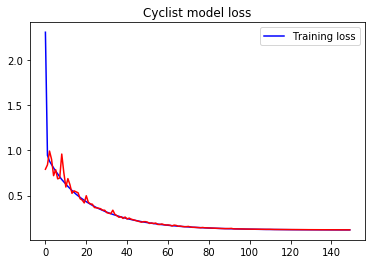

In [12]:
history.history.keys()
ax1,=plt.plot( history.history['loss'], c='b', label='Training loss')
ax2,=plt.plot( history.history['val_loss'], c='r', label='Validation loss')

plt.legend(handles=[ax1,ax2])
plt.title('Cyclist model loss')
plt.show()

In [ ]:
# final_model.compile(loss=v3_displacement_error, optimizer=adadelta, metrics=mtrc)
# final_model.load_weights('home+ '/repo/planning/traj_pred/total_model_history/veh_weights.h5'')

In [ ]:
# ##prediction
# # from utilities import get_position_sequence
# def get_position_sequence(prev, new):
#     arr = np.delete(prev, 0, 0)
#     a=np.vstack((arr,new))
#     return a 

# def get_sequence_prediction(X_position_test, i):
#     results =[]
#     s=X_position_test[i]
#     for count in range(0,50):
        
#         result = final_model.predict(np.array([s]))
# #         print(result)
#         results.append(result[0])
#         s = get_position_sequence(s, result)
#     results=np.array(results)
# #     print(s.shape,results.shape)
    
#     return results

# # i= np.random.randint(0, len(X_test))
# # results = get_sequence_prediction(X_test, i)
# # print(results.shape)

# test=np.load('vehicle_test_history.npy')
# v_predict=[]
# print(len(test))
# for i in range(len(test)):
#     print(i)
#     results = get_sequence_prediction(test, i)
#     v_predict.append(results)
# np.save("v_predictions",v_predict)

# print('done')

In [ ]:
# print(np.array(v_predict).shape)
# np.save("v_predictions",v_predict)
# print('done')

In [ ]:
# i= np.random.randint(0, len(X_test))


# # In[ ]:
# # i =2273

# # i=1574
# # i=3070

# # i=387,39
# # i=667
# # i=15
# print("showing trip", i)


# # from utilities import get_position_sequence
# def get_position_sequence(prev, new):
#     arr = np.delete(prev, 0, 0)
#     a=np.vstack((arr,new))
#     return a 

# def get_sequence_prediction(X_position_test, i):
#     results =[]
#     s=X_position_test[i]
#     for count in range(0,12):
        
#         result = final_model.predict(np.array([s]))
# #         print(result)
#         results.append(result[0])
#         s = get_position_sequence(s, result)
#     results=np.array(results)
# #     print(s.shape,results.shape)
    
#     return results

# results = get_sequence_prediction(X_test, i)

# # print(len(results))
# # print("sss",results)

# ax1 =plt.scatter(y_test[i][:,0],y_test[i][:,1],color='b',label='Ground truth')

# ax2 =plt.scatter(X_test[i][:,0],X_test[i][:,1],color='r', label='Training segment')


# ax3 =plt.scatter(results[:,0],results[:,1],color='g', label='Prediction')
# # ax3 =plt.scatter(result[0][0],result[0][1],color='g', label='Prediction')

# plt.legend(handles=[ax1, ax2, ax3])
# plt.show()

# distance = v3_displacement_error(results,y_test[i] )
# avg = K.mean(distance)
# pl =[]
# # tf.print(distance,output_stream=sys.stderr)
# with tf.compat.v1.Session() as sess: pl=distance.eval(), print(distance.eval(),'\naverage',avg.eval()) 
# import matplotlib.pyplot as plt
# # print(pl[0])
# plt.plot(pl[0])
# plt.title('Displacement error')
# plt.show()

In [ ]:
# final_displacement=[]
# avg_displacement=[]

# # for idx in range(0,len(X_test)):
# for idx in range(0,1000):
#     p=[]
#     re= get_sequence_prediction(X_test, idx)
#     distance = v3_displacement_error(re,y_test[idx] )
#     avg = K.mean(distance)
    
#     with tf.compat.v1.Session() as sess:
#         p=distance.eval()
#         ax =avg.eval()
# #     print(p,ax)
#     final_displacement.append(p)
#     avg_displacement.append(ax)

# final_displacement = np.array(final_displacement)
# sec=[]

# for j in range(0,final_displacement.shape[1]):
#     displacement = sum(final_displacement[:,j])/len(final_displacement)
    
#     sec.append(displacement)
# print("Final displacement error:",sec[-1])
# print("Average displacement error:",sum(avg_displacement)/len(avg_displacement))

# print(sec)
# plt.plot(sec)
# plt.title("average displacement error at each timestep")
# plt.show()



In [ ]:
# history2 = pickle.load(open( cwd+ '/saved_model/lab1_txt_max_history_mae_adadelta_600.sav',  "rb") ) 
# history3 = pickle.load(open( cwd+ '/saved_model/lab1_txt_max_history_mae_adadelta.sav',  "rb") )
# print(len(history.history['loss']))
# # plt.plot(range(600,1100),history.history['loss'], c='b')
# # plt.plot( range(300,600), history2['loss'], c='b')
# plt.plot( history3['loss'], c='b')
# plt.title('train loss')

# # plt.plot(range(600,1100),history.history['val_loss'], c='r')
# # plt.plot( range(300,600), history2['val_loss'], c='r')
# plt.plot( history3['val_loss'], c='r')
# plt.title('loss')


# plt.show()